In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from scipy.signal import argrelextrema

import matplotlib as plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [7]:
def featurize_ohlcv(df):
    # Feature engineering: returns, volatility, rolling statistics, etc.
    df['returns'] = df['close'].pct_change()
    df['volatility'] = df['returns'].rolling(10).std()
    df['rolling_mean'] = df['close'].rolling(10).mean()
    df['rolling_min'] = df['close'].rolling(10).min()
    df['rolling_max'] = df['close'].rolling(10).max()
    df['vol_zscore'] = (df['volume'] - df['volume'].rolling(20).mean()) / df['volume'].rolling(20).std()
    # Add more technical/mean-reversion/choppiness indicators as needed
    return df.dropna()

def label_states(df):
    # Identify local minima/maxima
    window = 5
    mins = argrelextrema(df['close'].values, np.less_equal, order=window)[0]
    maxs = argrelextrema(df['close'].values, np.greater_equal, order=window)[0]
    labels = pd.Series('no_label', index=df.index)
    
    # Rising: from minimum to next maximum, never drops below start
    for min_idx in mins:
        min_idx = int(min_idx)
        end_idx_candidates = [int(i) for i in maxs if int(i) > min_idx]
        if not end_idx_candidates:
            continue
        end_idx = end_idx_candidates[0]
        segment = df['close'].iloc[min_idx:end_idx+1]
        if (segment.min() == segment.iloc[0]) and (segment.max() == segment.iloc[-1]):
            if not (segment < segment.iloc[0]).any():
                labels.iloc[min_idx:end_idx+1] = 'rising'
    
    # Falling: from maximum to next minimum, never rises above start
    for max_idx in maxs:
        max_idx = int(max_idx)
        end_idx_candidates = [int(i) for i in mins if int(i) > max_idx]
        if not end_idx_candidates:
            continue
        end_idx = end_idx_candidates[0]
        segment = df['close'].iloc[max_idx:end_idx+1]
        if (segment.max() == segment.iloc[0]) and (segment.min() == segment.iloc[-1]):
            if not (segment > segment.iloc[0]).any():
                labels.iloc[max_idx:end_idx+1] = 'falling'
    
    # Steady: low rolling volatility, close near mean
    steady_cond = (df['volatility'] < 0.01) & (np.abs(df['close'] - df['rolling_mean'])/df['rolling_mean'] < 0.005)
    labels[steady_cond] = 'steady'
    
    # Choppy: high volatility, price mean-reverts
    choppy_cond = (df['volatility'] > 0.02) & (np.abs(df['close'] - df['rolling_mean'])/df['rolling_mean'] < 0.03)
    labels[choppy_cond] = 'choppy'
    
    df['label'] = labels
    return df

def fit_classifiers(df):
    features = ['returns', 'volatility', 'rolling_mean', 'vol_zscore']  # add others as engineered
    X = df[features]
    y = df['label']
    X = StandardScaler().fit_transform(X)
    
    # Logistic Regression
    lr = LogisticRegression(max_iter=500)
    lr.fit(X, y)
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X, y)
    
    # Neural Network
    nn = MLPClassifier(hidden_layer_sizes=(64, 16), max_iter=500)
    nn.fit(X, y)
    
    return {'logreg': lr, 'rf': rf, 'nn': nn}

def markov_transition_matrix(labels):
    # Build empirical transition probability matrix
    states = labels.unique()
    matrix = pd.DataFrame(0, index=states, columns=states, dtype=float)
    
    for (a, b) in zip(labels[:-1], labels[1:]):
        if (a in states) and (b in states):
            matrix.loc[a, b] += 1
    
    matrix = matrix.div(matrix.sum(axis=1), axis=0)
    return matrix

In [8]:
df = pd.read_csv('20250202-20170908_BTC-USDT_1D.csv')#, skip_blank_lines=True, parse_dates=["timestamp"], dayfirst=False)

df = featurize_ohlcv(df)
df = label_states(df)
classifiers = fit_classifiers(df)
transition_matrix = markov_transition_matrix(df['label'])

In [12]:
print("Label distribution:")
print(df['label'].value_counts())

print(transition_matrix)
print(classifiers)

Label distribution:
falling     872
choppy      757
rising      743
no_label    257
steady       24
Name: label, dtype: int64
            rising   falling    choppy  no_label    steady
rising    0.755047  0.109017  0.117093  0.013459  0.005384
falling   0.082664  0.708381  0.192882  0.005741  0.010333
choppy    0.126816  0.199472  0.619551  0.052840  0.001321
no_label  0.031128  0.054475  0.128405  0.766537  0.019455
steady    0.208333  0.375000  0.000000  0.208333  0.208333
{'logreg': LogisticRegression(max_iter=500), 'rf': RandomForestClassifier(n_estimators=50), 'nn': MLPClassifier(hidden_layer_sizes=(64, 16), max_iter=500)}


<AxesSubplot:>

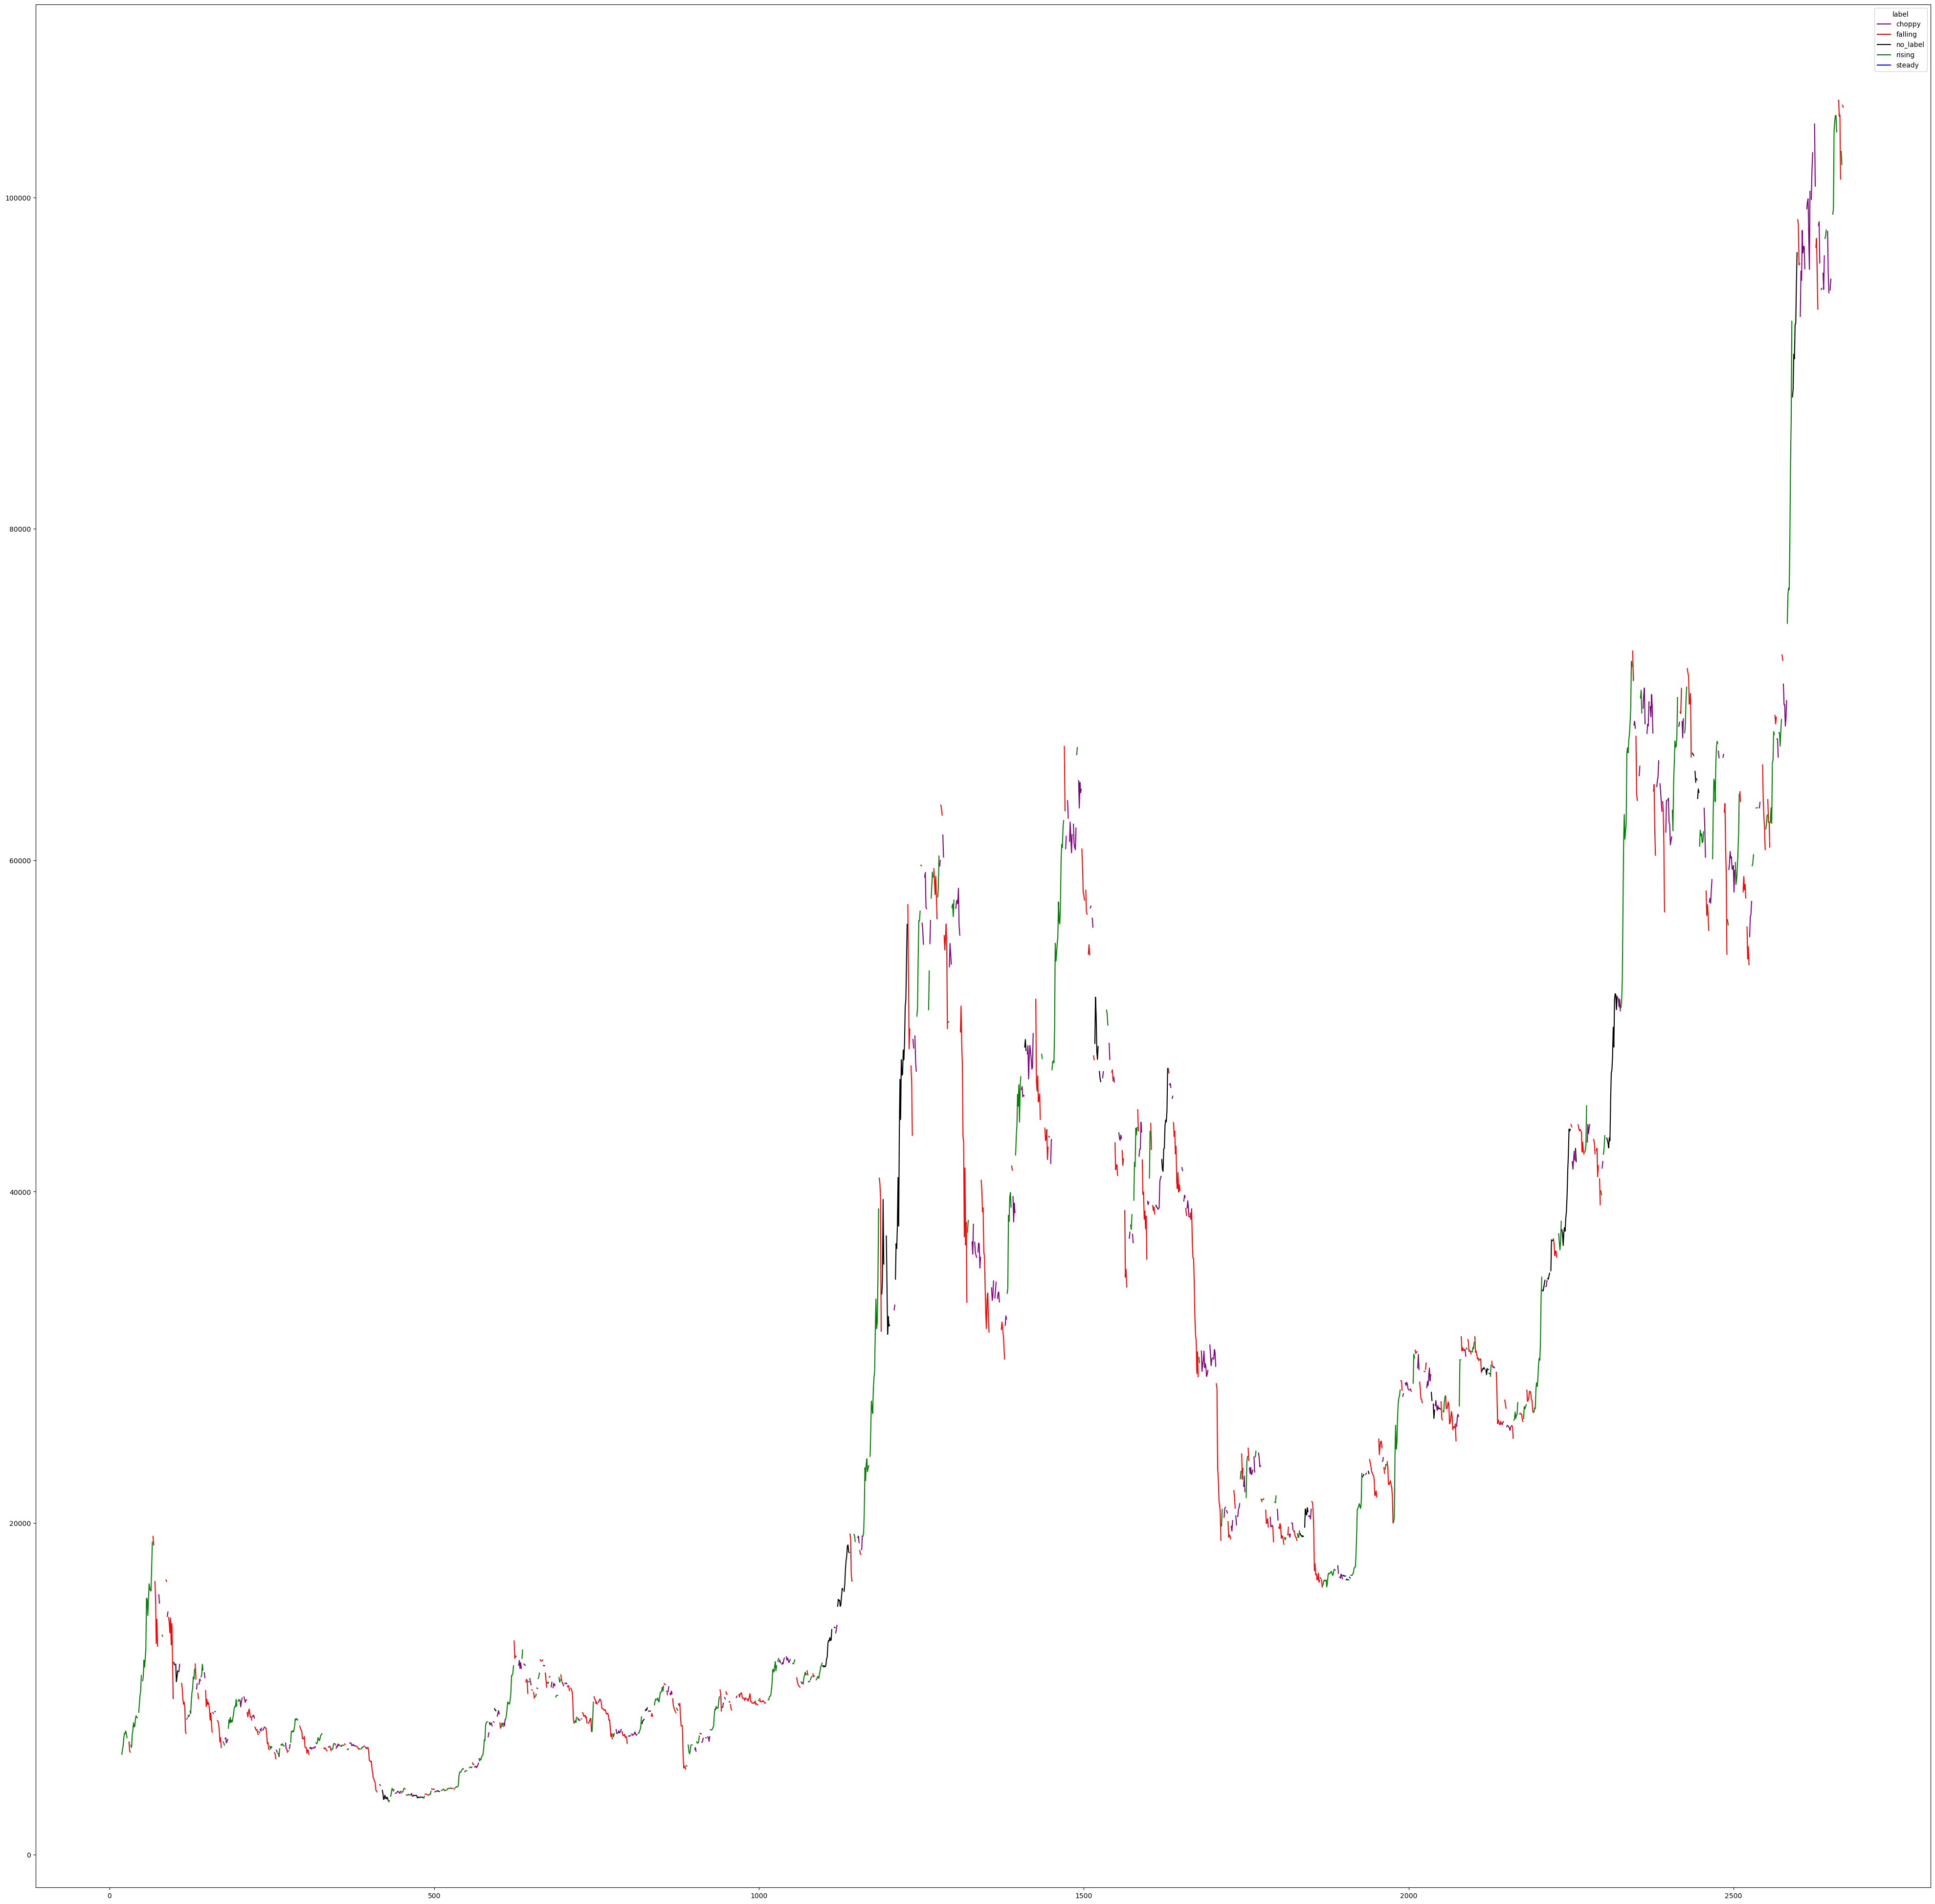

In [11]:
graph_df = df.set_index('label', append=True)['close']
graph_df = graph_df.unstack('label')
colors_map = {'steady': 'blue',
              'falling': 'red',
              'rising': 'green',
              'choppy': 'purple',
              'no_label': 'black',
             }
colors_map[np.nan] = 'black'

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)